In [2]:
# Useful starting lines
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from helper import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

# Generate data

We provide a helper function which generates artificial datasets

In [3]:
NUM_SAMPLES = 100

blobs_train, blobs_test = generate_dataset("blobs", NUM_SAMPLES)
moons_train, moons_test = generate_dataset("moons", NUM_SAMPLES)
xor_train, xor_test = generate_dataset("xor", NUM_SAMPLES)
squares_train, squares_test = generate_dataset("bar", NUM_SAMPLES)

# The generate_dataset function returns PyTorch dataset objects
type(blobs_train), type(blobs_test)

(torch.utils.data.dataset.Subset, torch.utils.data.dataset.Subset)

In [4]:
print(blobs_train.dataset)

Let us plot the train and the test data sets. Note the differences between the two.

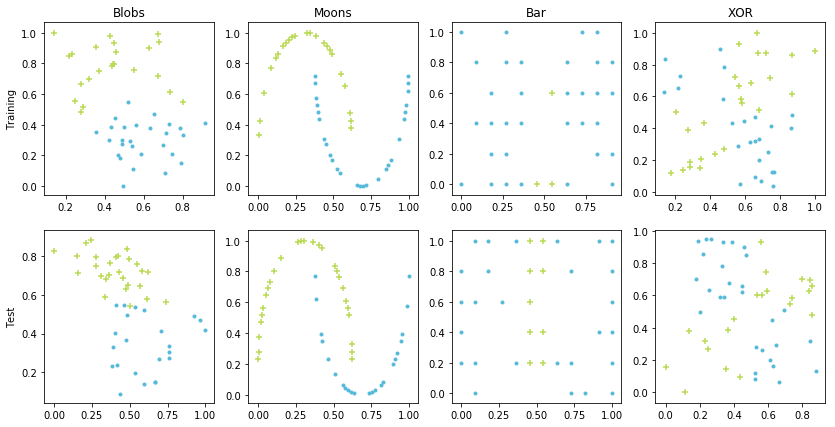

In [5]:
datasets = [
    ("Blobs", blobs_train, blobs_test),
    ("Moons", moons_train, moons_test),
    ("Bar", squares_train, squares_test),
    ("XOR", xor_train, xor_test)
]

visualize_datasets(datasets)

# Optimizing using PyTorch

Write an optimizer in PyTorch by taking using its default SGD class

In [13]:
def optimize(train_data, test_data, model, loss_fn = torch.nn.CrossEntropyLoss(), lr = 0.1):
    """
    Stochastic Gradient Descent optimizer
    
    :param train_data: torch.utils.data.dataset.Subset
    :param test_data: torch.utils.data.dataset.Subset
    :param model: torch.nn.Module (see https://pytorch.org/docs/stable/nn.html)
    :param loss_fn: torch.nn.modules.loss (see https://pytorch.org/docs/stable/nn.html#id51)
    :param lr: float, learning rate
    
    :return:
    - objectives, a list of loss values on the test dataset, collected at the end of each pass over the dataset (epoch)
    """
    # defatult pytorch functions which are useful for loading testing and training data
    train_loader = data.DataLoader(train_data, batch_size=10, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=NUM_SAMPLES)
    losses = []
        
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: Define SGD optimizer with learning rate = lr
    # HINT: Use torch.optim.SGD and model.parameters()
    # ***************************************************
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # Run SGD
    for epoch in range(1000):
        for minibatch, label in train_loader:
            
            optimizer.zero_grad() # Sets the previously computed gradients to zero to prevent accumulation
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: prediction on minibatch
            # HINT: Use model.forward
            # ***************************************************
            prediction = model.forward(minibatch)
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: compute the loss on prediction
            # HINT: Use loss_fn
            # ***************************************************
                                         
            loss = loss_fn(prediction, label.long())
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: compute the minibatch gradient
            # HINT: Use loss.backward!
            # ***************************************************
            loss.backward()
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: perform an SGD step
            # HINT: Use optimizer.step!
            # ***************************************************
            optimizer.step()
            
        # Compute the test loss
        # we let torch know that we dont intend to call .backward
        with torch.no_grad():
            test_data, test_labels = next(iter(test_loader))  # load the one and only test batch
            
            # ***************************************************
            # INSERT YOUR CODE HERE
            # TODO: compute the test prediction and test loss
            # ***************************************************
            prediction = model.forward(test_data)
            loss = loss_fn(prediction, test_labels.long())

            losses.append(loss.item())

            # Print the test loss to monitor progress
            if epoch % 100 == 0:
                print(epoch, loss.item())
                
    return losses

# RBF Kernel

An RBF kernel is the most commonly used `out of the box` kernel method for non-linear data. Intuitively, an RBF-kernel blurs the training data and uses this for classification i.e. the individual green and blue points above get blurred to make green and blue regions, which are used to make predictions. A critical parameter `sigma` defines the width of this blurring---large `sigma` results in more blurring.

See [here](https://github.com/epfml/ML_course/blob/master/lectures/07/lecture07b_kernelRidge.pdf) for more information on the `kernel trick` and [here](https://www.cs.huji.ac.il/~shais/Lectures2014/lecture8.pdf) for an indepth mathematical treatment. Here, we will try develop an intuition for the RBF kernel.

In [14]:
class RadialBasisFunction(torch.nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.gamma = 1 / (2 * sigma ** 2)
        self.num_classes = 2
        self.name = 'RBF'
    
    def init_params(self, train_data):
        # data reshaping to do torch broadcasting magic
        data_matrix = train_data.dataset.tensors[0][train_data.indices, :]
        self.data_matrix = data_matrix.t().view(1, *data_matrix.t().shape)
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: initialize parameters alpha to 0
        # HINT: use torch.zeros
        # ***************************************************
        zeros = torch.zeros(data_matrix.shape[0], self.num_classes)
        
        self.alpha = torch.nn.Parameter(zeros)

    def forward(self, minibatch):
        minibatch = minibatch.view(*minibatch.shape, 1)
        K = torch.exp(
            -self.gamma * torch.sum((self.data_matrix - minibatch) ** 2, dim=1, keepdim=True)
        ).squeeze()
        return K @ self.alpha


Try you code on the blobs data set.

In [15]:
rbf_model = RadialBasisFunction(0.5)
rbf_model.init_params(blobs_train)
rbf_blob_losses = optimize(blobs_train, blobs_test, rbf_model)

0 0.476187527179718
100 0.15132910013198853
200 0.1403919756412506
300 0.15610605478286743
400 0.1349283754825592
500 0.15942597389221191
600 0.15761570632457733
700 0.1505601406097412
800 0.1477344036102295
900 0.1631193310022354


Plot the training data points and the predictions made

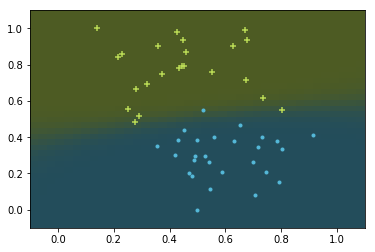

In [16]:
ax = plt.gca()
predict_grid(rbf_model, ax)
visualize_one_dataset(blobs_train, ax)

## Effect of `sigma`

Plot the results while varying the value of `sigma` in [0.1, 0.5, 1]. What do you observe? Which is the best value?


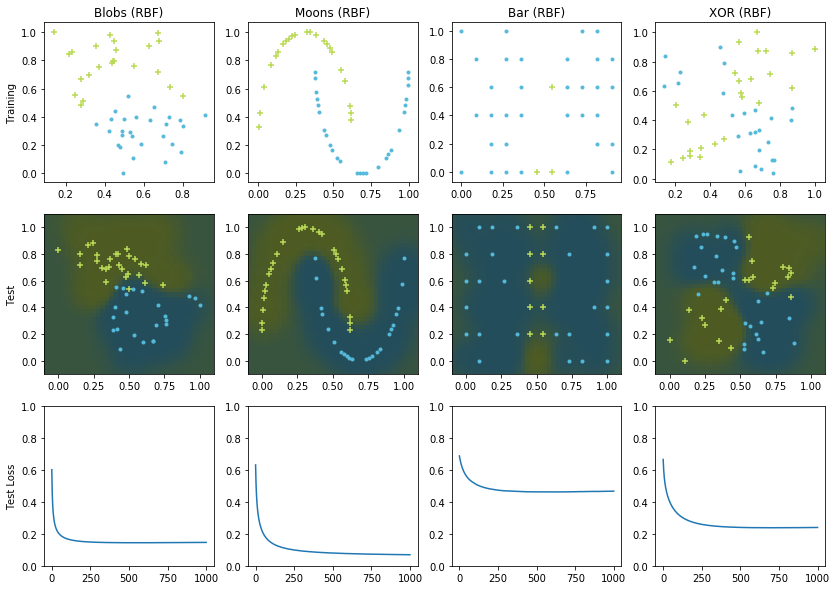

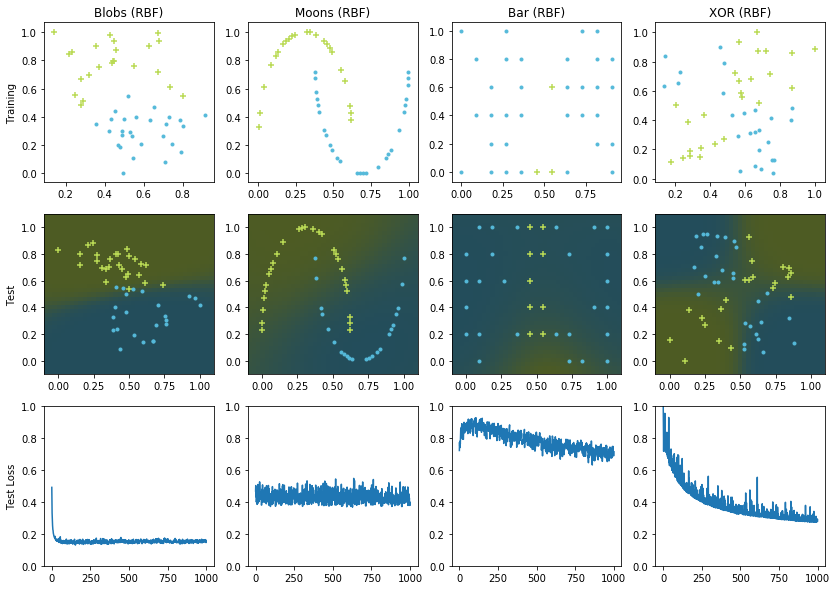

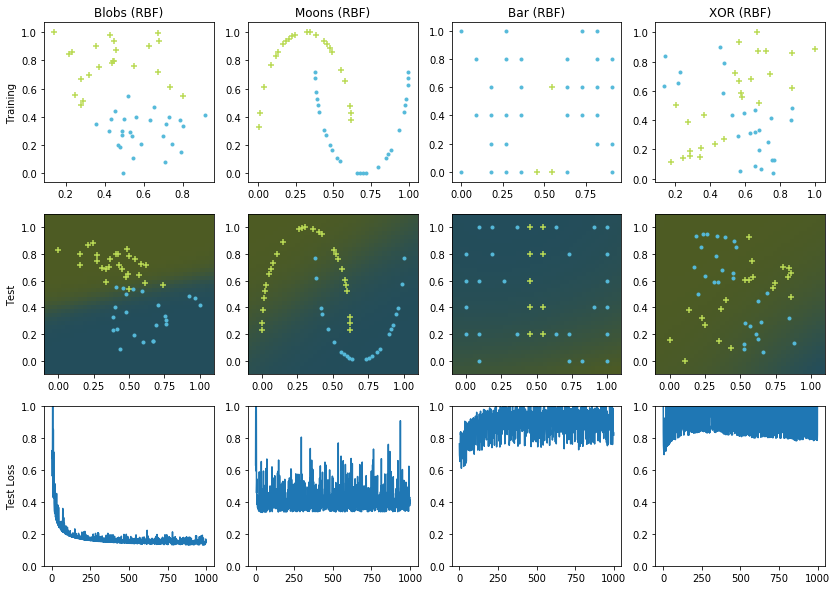

In [22]:
sigmas = [0.1, 0.5, 1]
for sigma in sigmas:
    rbf_model = RadialBasisFunction(sigma)
    visualize_predictions(datasets, rbf_model, optimize)

# We observe that the best value for sigma is for 0.1, we have the least test loss. 

# Neural Networks

We will create a simple 2 layer neural network using the default functions provided by PyTorch

In [19]:
class NeuralNetwork(torch.nn.Sequential):
    def __init__(self, hidden_layer_size):
        self.name = 'NN'
        self.num_classes = 2
        self.n_features = 2
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: Define your neural network model with ReLU
        # HINT: Use torch.nn.Sequential and torch.nn.ReLU
        # ***************************************************
        super().__init__(
                torch.nn.Linear(self.n_features,hidden_layer_size),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(hidden_layer_size, self.num_classes)
            )
        
    def init_params(self, train_data):
        ''' No need to do anything since it is taken care of by torch.nn.Sequential'''
    
        

Plot the results while varying the size of the hidden layer in [20, 200, 1000]

What do you observe?

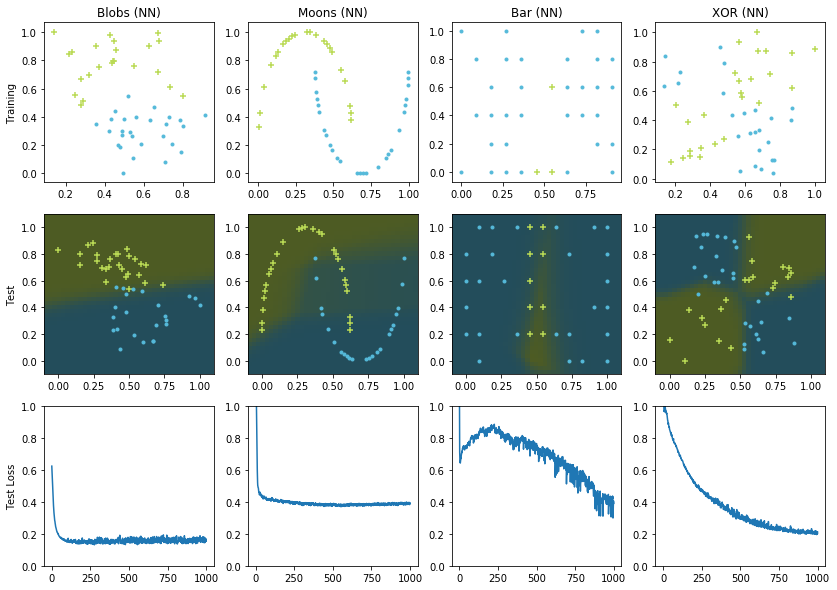

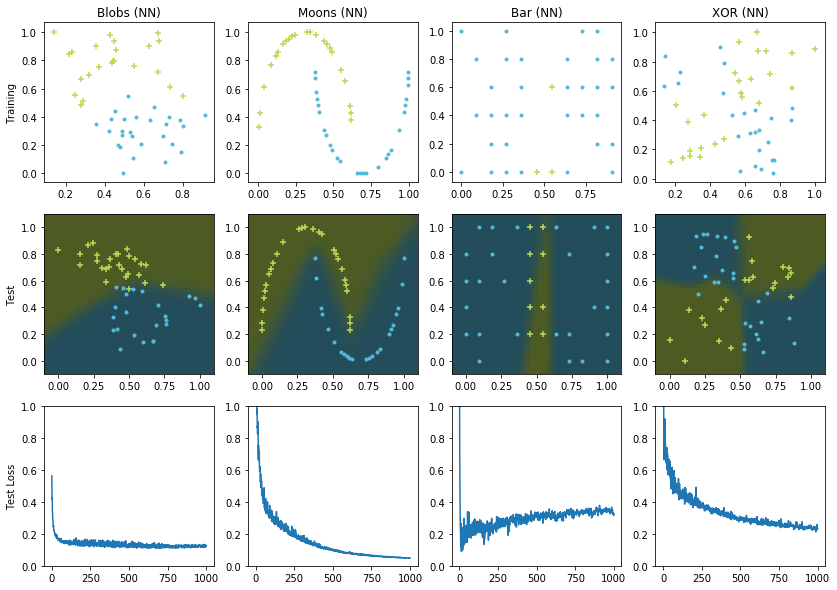

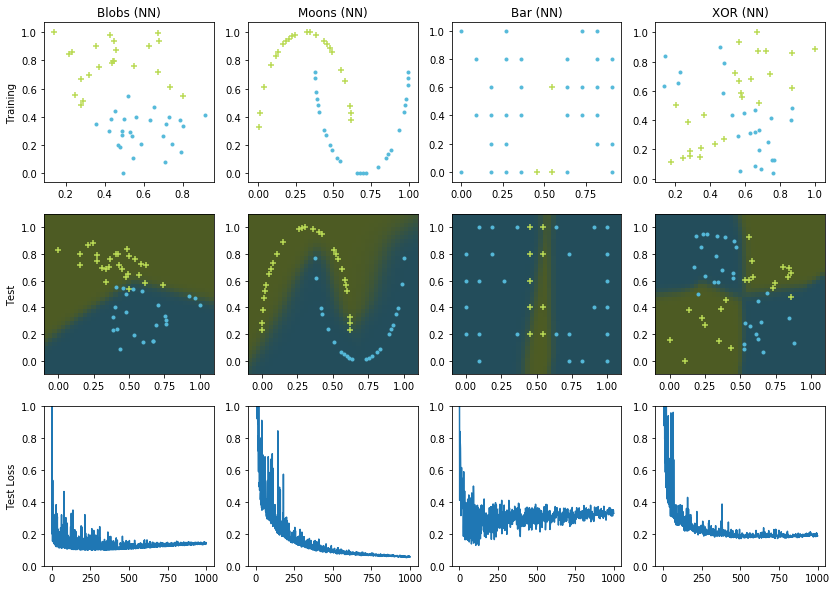

In [21]:
# As the hidden layer size increases, the test loss graph gets more and more noisy. This may suggests overfitting.
hidden_layer_sizes = [20, 200, 1000]

for hls in hidden_layer_sizes:
    nn_model = NeuralNetwork(hls)
    visualize_predictions(datasets, nn_model, optimize)

Also try increase the number of layers. How does this effect the classifier learnt?

[This](https://playground.tensorflow.org/) is a cool website where you can play around more with training of neural networks on toy datasets.

In [29]:
# Neural Network with more linear layers
class NeuralNetwork2(torch.nn.Sequential):
    def __init__(self, hidden_layer_size):
        self.name = 'NN'
        self.num_classes = 2
        self.n_features = 2
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: Define your neural network model with ReLU
        # HINT: Use torch.nn.Sequential and torch.nn.ReLU
        # ***************************************************
        super().__init__(
                torch.nn.Linear(self.n_features,hidden_layer_size),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(hidden_layer_size,hidden_layer_size),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(hidden_layer_size,hidden_layer_size),
                torch.nn.ReLU(inplace=True),
                torch.nn.Linear(hidden_layer_size, self.num_classes)
            )
        
    def init_params(self, train_data):
        ''' No need to do anything since it is taken care of by torch.nn.Sequential'''
         

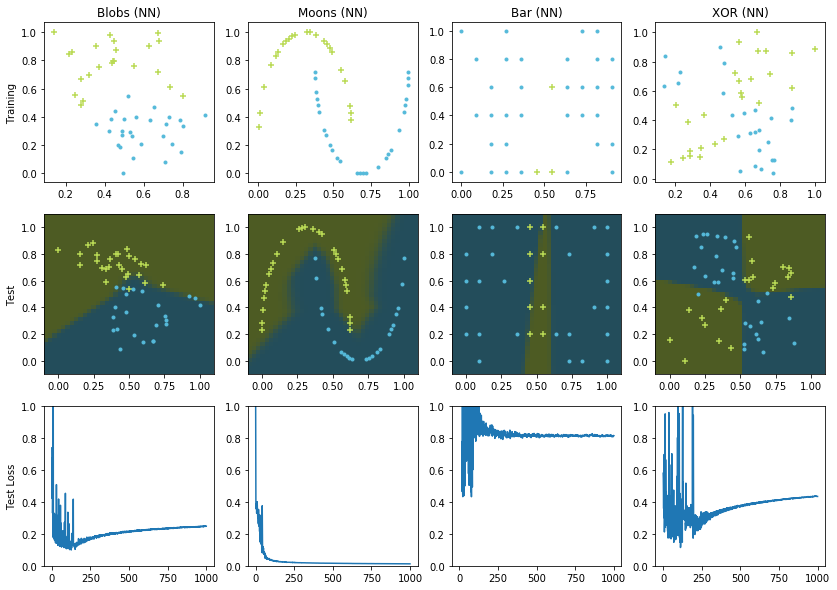

In [30]:
nn_model = NeuralNetwork2(480)
visualize_predictions(datasets, nn_model, optimize)

# The model is more complex, so it does not generalize well. The test loss explodes in this case.
# This may suggest overfitting.